In [1]:
import torch
from torch import nn
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
data = load_breast_cancer()
x, y = data['data'], data['target']

x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8)

def standardise(x, means, stds):
    return (x - means) / stds 

In [3]:
class GaussianKernel():
    """ The kernel measures the similarity between x1 and x2. The higher sigma is,
    the higher will be the returned similarity. For x1 = x2 the similarity is 1. If
    x1 and x2 have a high distance, the returned similarity will be ≈ 0.
    """
    def __init__(self, sigma):
        self.sigma = sigma
    
    def __call__(self, x1, x2):
        return torch.exp(-1 * torch.sum((x1 - x2) ** 2) / (2 * self.sigma ** 2))

In [4]:
""" Running some tests.
"""

vec1 = torch.Tensor([1, 1, 2])
for sigma in [0.5, 1., 3.]:
    kernel = GaussianKernel(sigma)
    for vec2 in [
        torch.Tensor([1, 1, 2]), 
        torch.Tensor([1, 1, 1]), 
        torch.Tensor([1, 0, 0])
    ]:
        sim = kernel(vec1, vec2)
        print(f"For sigma = {sigma} the similarity between {vec1.numpy()} and {vec2.numpy()} is {sim}")
    print()

For sigma = 0.5 the similarity between [1. 1. 2.] and [1. 1. 2.] is 1.0
For sigma = 0.5 the similarity between [1. 1. 2.] and [1. 1. 1.] is 0.1353352814912796
For sigma = 0.5 the similarity between [1. 1. 2.] and [1. 0. 0.] is 4.539993096841499e-05

For sigma = 1.0 the similarity between [1. 1. 2.] and [1. 1. 2.] is 1.0
For sigma = 1.0 the similarity between [1. 1. 2.] and [1. 1. 1.] is 0.6065306663513184
For sigma = 1.0 the similarity between [1. 1. 2.] and [1. 0. 0.] is 0.08208499848842621

For sigma = 3.0 the similarity between [1. 1. 2.] and [1. 1. 2.] is 1.0
For sigma = 3.0 the similarity between [1. 1. 2.] and [1. 1. 1.] is 0.9459594488143921
For sigma = 3.0 the similarity between [1. 1. 2.] and [1. 0. 0.] is 0.757465124130249



In [5]:
def hinge_loss(y_pred, y_true):
    """ Hinge loss, used for large margin classifiers. 
    If y = 1 and y_pred >= 1, the loss is 0, otherwise its 1 - y_pred
    If y = 0 and y_pred <= -1, the loss is 0, otherwise its 1 + y_pred
    y_pred: predictions of the model of shape (m, 1). Can be outside of range [0, 1]
    y_true: binary labels of shape (m, 1), can be either 0 or 1.
    """
    y_true = torch.where(y_true == 0, -1.0 * torch.ones_like(y_true).float(), y_true.float())
    l = torch.max(torch.zeros_like(y_true), 1 - y_true * y_pred)
    return torch.mean(l)

class SVMClassifier(nn.Module):
    """ Support vector machine used for classification. 
    Data should always be normalised before being passed into the SVM,
    otherwise the vector similarity computed by the kernel function will penalise features
    with low values.
    This works only in the binary case, where y = 1 or y = 0.
    In multiclass classification the one vs all method would be used.
    TODO should work for kernel.
    """
    def __init__(self, n_features, c=2.0, kernel=None):
        """
        c: influence the hinge loss has compared to L2 regularization.
        kernel: callable which computes similarity between two vector arguments.
        """
        super().__init__()
        self.c = c
        self.kernel = kernel
        self.w = nn.Parameter(torch.randn((n_features, 1), requires_grad=True))
        self.b = nn.Parameter(torch.zeros((1, ), requires_grad=True))
    
    def forward(self, x):
        z = x @ self.w + self.b
        return z
    
    def predict(self, x):
        y_pred = self.forward(x)
        return torch.where(y_pred >= 0, torch.ones_like(y_pred), torch.zeros_like(y_pred))
    
    def compute_loss(self, y_pred, y_true):
        loss_1 = hinge_loss(y_pred, y_true)
        loss_2 = self.w.T @ self.w
        return self.c * loss_1 + loss_2

In [6]:
means, stds = np.mean(x_train, axis=0), np.std(x_train, axis=0)

x_train, x_val = standardise(x_train, means, stds), standardise(x_val, means, stds)
x_train, x_val = torch.FloatTensor(x_train), torch.FloatTensor(x_val)
y_train, y_val = torch.LongTensor(y_train), torch.LongTensor(y_val) 

In [7]:
svm = SVMClassifier(n_features=x.shape[1], c=2.0)
optimiser = torch.optim.SGD(svm.parameters(), lr=0.04)

In [8]:
n_epochs = 50
train_losses, val_losses = [], []

for epoch in range(1, n_epochs + 1):
    svm.train()
    optimiser.zero_grad()
    y_pred = svm(x_train)
    train_loss = svm.compute_loss(y_pred, y_train.view((-1, 1)))
    train_loss.backward()
    optimiser.step()
    
    with torch.no_grad():
        svm.eval()
        y_pred = svm(x_val)
        val_loss = svm.compute_loss(y_pred, y_val.view((-1, 1)))
        
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

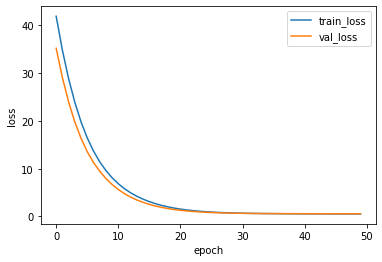

In [9]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [21]:
with torch.no_grad():
    svm.eval()
    y_pred = svm.predict(x_val).squeeze()
    val_acc = np.mean(y_pred.numpy() == y_val.numpy())
    
print(f"The classifier has a validation set accuracy of {round(val_acc  * 100, 2)}%")

The classifier has a validation set accuracy of 94.74%
